# A network-based method to harmonize data classifications
## SCIAN-CIIU-NAICS-ENCADENADO

In [1]:
## Cargamos paquetes 
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from py2cytoscape import util as cy 
from py2cytoscape import cytoscapejs as cyjs
import requests
import json
from IPython.display import Image
from IPython.display import Markdown as md
import os 

<IPython.core.display.Javascript object>

In [2]:
## Definimos rutas donde se encuentran las correspondencias scian-ciiu
FILE_PATH = os.getcwd()
CWS_PATH = os.path.abspath(os.path.join(*[".."]*3, "empleo"))
CIIU_SCIAN_FILE_PATH = os.path.join(CWS_PATH, "scian-ciiu", "ciiu-4_scian-2018.json")
CIIU_NAICS_FILE_PATH = os.path.join(CWS_PATH, "naics", "output","isic_4_to_naics_2017.json")
OUTPUT_PATH = os.path.abspath(os.path.join("..", "output"))
DATOS_PATH = os.path.abspath(os.path.join("..", "datos"))


In [3]:
# Cargamos las correspondencias entre CIIU Rev 4-SCIAN 2018
ciiu_scian = json.load(open(CIIU_SCIAN_FILE_PATH, "r"))
df_ciiu_scian = pd.DataFrame(
    [(f"{int(ciiu):04}", scian) for ciiu, scian_clases in ciiu_scian.items() for scian in scian_clases]
    , columns = ["ciiu", "scian"]
)
df_ciiu_scian["scian"] = df_ciiu_scian["scian"].apply(lambda x : f"{x}-MEX")  
df_ciiu_scian

,ciiu,scian
0,0111,111110-MEX
1,0111,111121-MEX
2,0111,111122-MEX
3,0111,111129-MEX
4,0111,111131-MEX
...,...,...
1580,8430,931610-MEX
1581,8421,931710-MEX
1582,8422,931810-MEX
1583,9900,932110-MEX


In [4]:
# Cargamos las correspondencias entre CIIU Rev 4-NAICS 2017
ciiu_naics = json.load(open(CIIU_NAICS_FILE_PATH, "r"))
df_ciiu_naics = pd.DataFrame(
    [(f"{int(ciiu):04}", scian) for ciiu, scian_clases in ciiu_naics.items() for scian in scian_clases]
    , columns = ["ciiu", "naics"]
)
df_ciiu_naics["naics"] = df_ciiu_naics["naics"].apply(lambda x : f"{x}-USA")
df_ciiu_naics

,ciiu,naics
0,0111,111110-USA
1,0111,111120-USA
2,0111,111130-USA
3,0111,111140-USA
4,0111,111150-USA
...,...,...
1648,9609,812910-USA
1649,9609,812930-USA
1650,9609,812990-USA
1651,9700,814110-USA


In [5]:
"""
generate graph/network here
"""

# empty graph/network
G = nx.Graph()
  

# add edges    
for k in df_ciiu_scian.index:
    i = tuple(df_ciiu_scian.iloc[[k]]["scian"].values)[0] 
    j = tuple(df_ciiu_scian.iloc[[k]]["ciiu"].values)[0] 
    G.add_edge(str(i),str(j)) 
    
for k in df_ciiu_naics.index:
    i = tuple(df_ciiu_naics.iloc[[k]]["ciiu"].values)[0] 
    j = tuple(df_ciiu_naics.iloc[[k]]["naics"].values)[0] 
    G.add_edge(str(i),str(j)) 

In [6]:
def basic_stats(G):
    print("nodes: %d" % G.number_of_nodes())
    print("edges: %d" % G.number_of_edges())

In [7]:
basic_stats(G)

nodes: 2561
edges: 3237


In [8]:
#gen sets
set_i = df_ciiu_scian[['scian']]
set_i = set_i.drop_duplicates(keep='first')
set_i['set_type']=int(1)

set_j = df_ciiu_scian[['ciiu']]
set_j = set_j.drop_duplicates(keep='first')
set_j['set_type']=int(2)

set_h = df_ciiu_naics[['naics']]
set_h = set_h.drop_duplicates(keep='first')
set_h['set_type']=int(3)

#set_i.scian = set_i.scian.astype(int)
#set_j.ciiu = set_j.ciiu.astype(int)
#set_h.naics = set_h.naics.astype(int)

# node attributes
node_type = set_i.set_index("scian").set_type.to_dict()
node_type.update(set_j.set_index("ciiu").set_type.to_dict() )
node_type.update(set_h.set_index("naics").set_type.to_dict() )

for k in node_type:
    node_type[k]=int(node_type[k])

# assign attributes to networkx G
nx.set_node_attributes(G,node_type,"n_type")


In [9]:
# move network from networkx to cy
G.node = G.nodes
cytoscape_network = cy.from_networkx(G)

In [10]:
# Basic Setup
PORT_NUMBER = 1234
IP = 'localhost'
BASE = 'http://' + IP + ':' + str(PORT_NUMBER) + '/v1/'
HEADERS = {'Content-Type': 'application/json'}
requests.delete(BASE + 'session')

<Response [200]>

In [11]:
res1 = requests.post(BASE + 'networks', data=json.dumps(cytoscape_network), headers=HEADERS)
res1_dict = res1.json()
new_suid = res1_dict['networkSUID']
requests.get(BASE + 'apply/layouts/force-directed/' + str(new_suid))

<Response [200]>

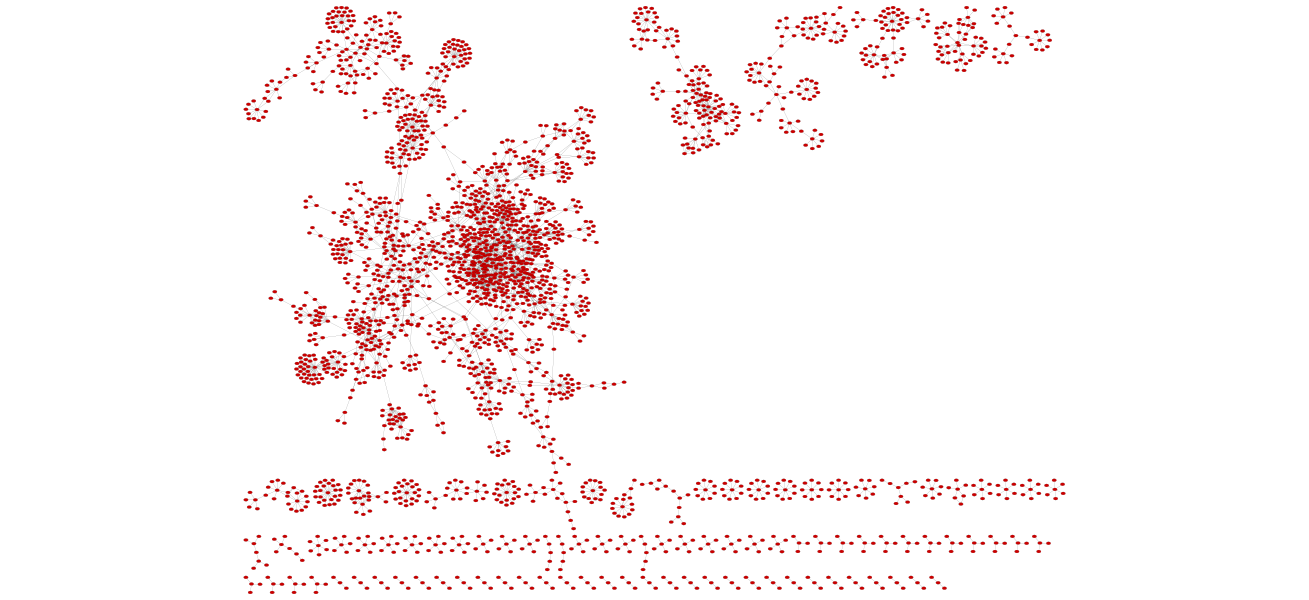

In [12]:
style_name = 'Basic_Style'

my_style = {
  "title" : style_name,
  "mappings" : [{
    "mappingType" : "passthrough",
    "mappingColumn" : "n_name",
    "mappingColumnType" : "String",
    "visualProperty" : "NODE_LABEL"
  },{
    "mappingType" : "discrete",
    "mappingColumn" : "n_type",
    "mappingColumnType" : "Double",
    "visualProperty" : "NODE_FILL_COLOR",
       "map" : [ {
      "key" : "1",
      "value" : "#CC0000"
    }, {
      "key" : "2",
      "value" : "#009999"
    }, {
      "key" : "3",
      "value" : "#e59710"
    }]  
  }], 
   'defaults': [{
       'visualProperty': 'EDGE_TRANSPARENCY', 
       'value': 200
  }, {
    "visualProperty" : "NODE_SIZE",
    'value': 50
  },{
    "visualProperty" : "EDGE_WIDTH",
    'value': 15
  },{
       'visualProperty': 'NODE_LABEL_TRANSPARENCY', 
       'value': 0
   }, {
       'visualProperty': 'NODE_TRANSPARENCY', 
       'value': 200
   }]
}


# Create new Visual Style
res = requests.post(BASE + "styles", data=json.dumps(my_style), headers=HEADERS)
new_style_name = res.json()['title']

# Apply it to current netwrok
requests.get(BASE + 'apply/styles/' + new_style_name + '/' + str(new_suid))

# Display
Image(BASE+'networks/' + str(new_suid) + '/views/first.png')

## 6 The complex case in a many-to-many mapping
### 6.1 When the network has a large connected component 

Let's consider a case where the concordance network has one large connected component. It may not be the only component, but let us say that it dominates the network significantly. In this case the method outlined this far is not suited to harmonize the classifications, as we would only have one (or very few) final classification.

We can however apply a modification of this method -- still based on network analysis -- that can provide an elegant solution, even though it is not error free.

The core idea behind the modified method is to identify the clusters (communities, more precisely) in the concordance network, and assign a new "target" classification to each of the clusters.

While a handful of components are small isolates, the majority of the concordance network is made of one large component, which is kept together only by few bridging nodes.

One solution is to use Cytoscape to identify this bridges and disconnect the components by hand. A quicker way to obtain the same result is to run a community discovery algorithm.

In this example I use 'label propagation' algorithm, but several options are possible.

In [13]:
from networkx.algorithms import community

In [14]:
C2 = community.label_propagation_communities(G)

In [15]:
list_comp2=sorted(C2, key = len, reverse=True)
nc2 = len(list_comp2)
nc2

350

In [16]:
# final concordance tables generation
C123 = pd.DataFrame([(n,c, 0) for c in range(nc2) for n in list_comp2[c]] , columns= ["code","code_N","s"])
C123


,code,code_N,s
0,445299-USA,0,0
1,461160-MEX,0,0
2,461213-MEX,0,0
3,463217-MEX,0,0
4,467115-MEX,0,0
...,...,...,...
2556,238290-USA,347,0
2557,811212-USA,348,0
2558,9511,348,0
2559,221210-USA,349,0


In [17]:
C123["s"] = 3
C123.loc[C123.code.apply(lambda x: len(str(x))==4 or len(str(x))==3), "s"] = 1
C123.loc[C123.code.apply(lambda x: "MEX" in x), "s"] = 2
C123

,code,code_N,s
0,445299-USA,0,3
1,461160-MEX,0,2
2,461213-MEX,0,2
3,463217-MEX,0,2
4,467115-MEX,0,2
...,...,...,...
2556,238290-USA,347,3
2557,811212-USA,348,3
2558,9511,348,1
2559,221210-USA,349,3


In [18]:
## Generamos las correspondencias entre los sistemas de clasificación
codificacion = C123.copy()
codificacion.columns = ["codigo", "codigo_nuevo", "clasificador"]
codificacion.loc[codificacion.clasificador==1,"clasificador"] = "ciiu"
codificacion.loc[codificacion.clasificador==2,"clasificador"] = "scian"
codificacion.loc[codificacion.clasificador==3,"clasificador"] = "naics"
codificacion

/tmp/ipykernel_132618/2901506158.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'ciiu' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  codificacion.loc[codificacion.clasificador==1,"clasificador"] = "ciiu"


,codigo,codigo_nuevo,clasificador
0,445299-USA,0,naics
1,461160-MEX,0,scian
2,461213-MEX,0,scian
3,463217-MEX,0,scian
4,467115-MEX,0,scian
...,...,...,...
2556,238290-USA,347,naics
2557,811212-USA,348,naics
2558,9511,348,ciiu
2559,221210-USA,349,naics


In [19]:

## Add names and group for each new classification id

nombres = pd.read_csv(os.path.join(DATOS_PATH, "ciiu-rev-4_nombres.csv"))
nombres["ciiu"] = nombres["ciiu"].apply(lambda x : f"{x:04}")
codificacion = codificacion.query("clasificador=='ciiu'").merge(right=nombres, how="inner", left_on="codigo", right_on="ciiu")
codificacion["ciiu"] = codificacion["ciiu"].apply(lambda x: f"{x:04}")
codificacion


,codigo,codigo_nuevo,clasificador,ciiu,descripcion_ciiu
0,4722,0,ciiu,4722,Venta al por menor de bebidas en comercios esp...
1,4782,0,ciiu,4782,"Venta al por menor de productos textiles, pren..."
2,4741,0,ciiu,4741,Venta al por menor de ordenadores (computadora...
3,4789,0,ciiu,4789,Venta al por menor de otros productos en puest...
4,4781,0,ciiu,4781,"Venta al por menor de alimentos, bebidas y tab..."
...,...,...,...,...,...
411,2520,344,ciiu,2520,Fabricación de armas y municiones
412,2731,345,ciiu,2731,Fabricación de cables de fibra óptica
413,3040,346,ciiu,3040,Fabricación de vehículos militares de combate
414,9511,348,ciiu,9511,Reparación de ordenadores (computadoras) y equ...


In [20]:
nueva_codificacion = []
for i in codificacion.codigo_nuevo.unique():
    actividades_integra = codificacion.query(f"codigo_nuevo=={i}")["descripcion_ciiu"].to_list()
    if len(actividades_integra)==1:
        nueva_codificacion.append(
            (i,"".join(actividades_integra),"".join(codificacion.query(f"codigo_nuevo=={i}")["ciiu"]),",".join(codificacion.query(f"codigo_nuevo=={i}")["ciiu"].to_list()) )
        )
    else:
        print((i,"/-/".join(actividades_integra),min(codificacion.query(f"codigo_nuevo=={i}")["ciiu"].to_list()),",".join(codificacion.query(f"codigo_nuevo=={i}")["ciiu"].to_list())))
        nueva_codificacion.append(
            (i,"/-/".join(actividades_integra),min(codificacion.query(f"codigo_nuevo=={i}")["ciiu"].to_list()),",".join(codificacion.query(f"codigo_nuevo=={i}")["ciiu"].to_list()) )
        )

nueva_codificacion = pd.DataFrame(nueva_codificacion, columns = ["codigo_nuevo", "descripcion_codigo_nuevo", "ciiu_asignado", "actividades_ciiu_integra"])



(0, 'Venta al por menor de bebidas en comercios especializados (comercio al por menor de vinos y licores en comercios especializados)/-/Venta al por menor de productos textiles, prendas de vestir y calzado en puestos de venta y mercados (comercio al por menor de telas en puestos de venta y mercados)/-/Venta al por menor de ordenadores (computadoras), equipo periférico, programas de informática y equipo de telecomunicaciones en comercios especializados (comercio al por menor de computadoras y sus accesorios en comercios especializados)/-/Venta al por menor de otros productos en puestos de venta y mercados (comercio al por menor de lentes en puestos de venta y mercados)/-/Venta al por menor de alimentos, bebidas y tabaco en puestos de venta y mercados (comercio al por menor de carnes rojas en puestos de venta y mercados)/-/Venta al por menor de aparatos eléctricos de uso doméstico, muebles, equipo de iluminación y otros enseres domésticos en comercios especializados (comercio al por meno

In [21]:
nueva_codificacion

,codigo_nuevo,descripcion_codigo_nuevo,ciiu_asignado,actividades_ciiu_integra
0,0,Venta al por menor de bebidas en comercios esp...,4721,"4722,4782,4741,4789,4781,4759,4721,4751,4762,4..."
1,1,"Fabricación de artículos de cuchillería, herra...",2593,"2593,2824,2813,2930,2910,2818,2816,2821,3099"
2,2,Extracción de sal (minería de sal)/-/Elaboraci...,0893,"0893,1030,1079,1050"
3,3,Otras actividades de atención de la salud huma...,8690,8690
4,4,"Venta al por mayor de alimentos, bebidas y tab...",4630,4630
...,...,...,...,...
342,344,Fabricación de armas y municiones,2520,2520
343,345,Fabricación de cables de fibra óptica,2731,2731
344,346,Fabricación de vehículos militares de combate,3040,3040
345,348,Reparación de ordenadores (computadoras) y equ...,9511,9511


In [22]:
repeated_prefix = nueva_codificacion[nueva_codificacion.actividades_ciiu_integra.apply(lambda x : "," in x)].ciiu_asignado.apply(lambda x : x[:2]).unique()
nueva_codificacion["ciiu_nueva_cod"] = nueva_codificacion["ciiu_asignado"].copy()

for prefix in repeated_prefix:
    logical_test = nueva_codificacion.ciiu_asignado.apply(lambda x : x.startswith(prefix)) & nueva_codificacion.actividades_ciiu_integra.apply(lambda x : "," in x)
    num_repetidos = nueva_codificacion[logical_test].shape[0]
    nueva_codificacion.loc[logical_test, "ciiu_nueva_cod"] = [f"{prefix}-X{i:02}"for i in range(1,num_repetidos+1)]
    
nueva_codificacion = nueva_codificacion.sort_values(by="ciiu_nueva_cod").reset_index(drop=True)
nueva_codificacion


,codigo_nuevo,descripcion_codigo_nuevo,ciiu_asignado,actividades_ciiu_integra,ciiu_nueva_cod
0,77,Cultivo de frutas tropicales y subtropicales (...,0122,"0122,0127",01-X01
1,78,Cultivo de otros frutos y nueces de árboles y ...,0125,"0125,0126",01-X02
2,97,Cultivo de productos agrícolas en combinación ...,0143,"0150,0143",01-X03
3,120,Cultivo de otras plantas perennes (cultivo de ...,0129,"0129,0130",01-X04
4,146,Actividades poscosecha (despepite de algodón)/...,0163,"0163,0164",01-X05
...,...,...,...,...,...
342,95,"Lavado y limpieza, incluida la limpieza en sec...",9601,9601,9601
343,180,Peluquería y otros tratamientos de belleza,9602,9602,9602
344,144,Pompas fúnebres y actividades conexas (servici...,9603,9603,9603
345,96,Otras actividades de servicios personales n.c....,9609,9609,9609


In [23]:
## Get correspondence between the new classification and the ciiu-naics and ciiu-scian correspondences.
ciiu_recodificado_naics = {i:[] for i in nueva_codificacion["ciiu_nueva_cod"]}
ciiu_recodificado_scian = {i:[] for i in nueva_codificacion["ciiu_nueva_cod"]}


In [24]:
## Generate cw for ciiu-scian
ciiu_scian_merge = C123.query("s==2").merge(right=nueva_codificacion[["codigo_nuevo", "ciiu_nueva_cod"]], how = "left", left_on="code_N", right_on="codigo_nuevo")[["code", "ciiu_nueva_cod"]]
ciiu_scian_merge["code"] = ciiu_scian_merge["code"].apply(lambda x : x.replace("-MEX",""))
for scian, ciiu_nuevo in ciiu_scian_merge.to_records(index = False):
    ciiu_recodificado_scian[ciiu_nuevo].append(scian)
ciiu_recodificado_scian

{'01-X01': ['111332', '111337', '111331', '111333', '111334', '111991'],
 '01-X02': ['111412', '111413', '111338', '111339'],
 '01-X03': ['111995', '111993', '112991', '111994'],
 '01-X04': ['111429', '111419', '111423', '111999'],
 '01-X05': ['115113', '115112'],
 '0111': ['111131',
  '111132',
  '111191',
  '111110',
  '111121',
  '111129',
  '111992',
  '111139',
  '111140',
  '111199',
  '111194',
  '111152',
  '111195',
  '111122',
  '111192',
  '111151',
  '111193'],
 '0112': ['111160'],
 '0113': ['111215',
  '111216',
  '111217',
  '111416',
  '111213',
  '111214',
  '111218',
  '111411',
  '111211'],
 '0114': ['111930'],
 '0115': ['111910'],
 '0116': ['111920'],
 '0119': ['111941', '111942', '111219', '111421', '111422'],
 '0121': ['111335'],
 '0123': ['111329', '111321', '111310'],
 '0124': ['111336', '111415'],
 '0128': ['111414', '111212'],
 '0141': ['112110', '112131', '112120', '112139'],
 '0142': ['112920'],
 '0144': ['112410', '112420'],
 '0145': ['112211', '112212'],
 '

In [25]:
## Generate cw for ciiu-naics
ciiu_naics_merge = C123.query("s==3").merge(right=nueva_codificacion[["codigo_nuevo", "ciiu_nueva_cod"]], how = "left", left_on="code_N", right_on="codigo_nuevo")[["code", "ciiu_nueva_cod"]]
ciiu_naics_merge["code"] = ciiu_naics_merge["code"].apply(lambda x : x.replace("-USA",""))
ciiu_naics_merge = ciiu_naics_merge[~ciiu_naics_merge["ciiu_nueva_cod"].isna()]
for scian, ciiu_nuevo in ciiu_naics_merge.to_records(index = False):
    ciiu_recodificado_naics[ciiu_nuevo].append(scian)
ciiu_recodificado_naics

{'01-X01': ['111339'],
 '01-X02': ['111335', '111334', '111333'],
 '01-X03': ['112990'],
 '01-X04': ['111421'],
 '01-X05': ['115111', '115114'],
 '0111': ['111150',
  '111120',
  '111140',
  '111110',
  '111998',
  '111199',
  '111130',
  '111191',
  '111992'],
 '0112': ['111160'],
 '0113': ['111411', '111211', '111991'],
 '0114': ['111930'],
 '0115': ['111910'],
 '0116': ['111920'],
 '0119': ['111219', '111422', '111940'],
 '0121': ['111332'],
 '0123': ['111320', '111310'],
 '0124': ['111331'],
 '0128': ['111419'],
 '0141': ['112111', '112120', '112130', '112112'],
 '0142': ['112920'],
 '0144': ['112410', '112420'],
 '0145': ['112210'],
 '0146': ['112310', '112390', '112330', '112320', '112340'],
 '0149': ['112910', '112930'],
 '0161': ['115115', '115116', '115112', '115113'],
 '0162': ['115210'],
 '0170': ['114210'],
 '02-X01': ['113210', '113110'],
 '0220': ['113310'],
 '0240': ['115310'],
 '03-X01': ['114119', '114112', '311710', '114111'],
 '03-X02': ['112511', '112519', '112512']

In [26]:
nueva_codificacion = nueva_codificacion[["ciiu_nueva_cod", "actividades_ciiu_integra", "descripcion_codigo_nuevo"]]

In [27]:
## Save dictionaries
nueva_codificacion.to_csv(os.path.join(OUTPUT_PATH, "recodificacion_ciiu-rev-4.csv"), index = False)
json.dump(ciiu_recodificado_scian, open( os.path.join(OUTPUT_PATH, "ciiu_recodificado_scian_2018.json"), "w"))
json.dump(ciiu_recodificado_naics, open( os.path.join(OUTPUT_PATH, "ciiu_recodificado_naics_2017.json"), "w"))